## ATMS 523 - Module 5
### SeungUk Kim

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
# import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

In [2]:
# Load radar_parameters.csv data
radar_param = pd.read_csv('./homework/radar_parameters.csv', index_col=[0])
radar_param

### Part 1. Linear Regression

* Linear Regression
* Compared with baseline prediction

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [3]:
# Split training-testing: 70-30
Xtrain, Xtest, ytrain, ytest = train_test_split(radar_param.iloc[:,0:6].values, radar_param.iloc[:,6].values,
                                                train_size=0.7, random_state=0)
# Fit linear regression                                                
model = LinearRegression(fit_intercept=False)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

In [4]:
# Baseline prediction
# Z = 200 * (R**1.6). Thus, R = (Z/200)**(1/1.6)
# Zh = 10 * log10(Z). Thus, Z = 10**(Zh/10)
ypred_base = ((10**(Xtest[:,0]/10))/200)**(1/1.6)

In [134]:
from sklearn import metrics

print('Linear Regression')
print('R2 = ', metrics.r2_score(ypred, ytest))
print('RMSE = ', np.sqrt(metrics.mean_squared_error(ypred, ytest)), '\n')

print('Baseline Prediction')
print('R2 = ', metrics.r2_score(ypred_base, ytest))
print('RMSE = ', np.sqrt(metrics.mean_squared_error(ypred_base, ytest)))

Linear Regression
R2 =  0.9838061454436873
RMSE =  1.0492247752870645

Baseline Prediction
R2 =  0.23518915998899104
RMSE =  7.3523877227693095


Text(0.5, 0, 'Estimated R')

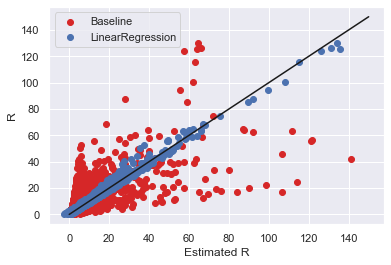

In [144]:
plt.plot([0,150],[0,150],'k')
plt.scatter(ypred_base, ytest, color='tab:red', label='Baseline')
plt.scatter(ypred, ytest, label='LinearRegression')
plt.legend()
plt.ylabel('R')
plt.xlabel('Estimated R')

Above shows that linear regression can outperform baseline prediction.

### Part 2. Grid Search

* Polynomial model for the order from 0 to 9

In [21]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import GridSearchCV

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

param_grid = {'polynomialfeatures__degree': np.arange(9),
              'linearregression__fit_intercept': [True, False],
              'linearregression__normalize': [True, False]}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)

* #5 = 7.1s
* #6 = 20.6s
* #7 = 77.7s
* #8 = 159.5s
* #9 = 440.3s

Roughly, it takes about 2-3 time more time by adding an order. If we are going to fit model for 0-21 order polynomial models, it will result in 440*(2^12) ~ 500hr from my own machine. I'm not sure about the order of calculation, but I assumed **O(n*log(n))** to fit the n-th order polynomial to put it simple. If it was true, it should take less than 30 min to fit up to 21th order polynomial model. However, it seems consuming more time. 


In [22]:
grid.fit(Xtrain, ytrain)

/opt/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/opt/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import 

GridSearchCV(cv=7,
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'linearregression__fit_intercept': [True, False],
                         'linearregression__normalize': [True, False],
                         'polynomialfeatures__degree': array([0, 1, 2, 3, 4, 5, 6, 7, 8])})

In [136]:
grid.best_params_

{'linearregression__fit_intercept': True,
 'linearregression__normalize': True,
 'polynomialfeatures__degree': 2}

In [23]:
model = grid.best_estimator_

In [24]:
y_test_gs = model.fit(Xtrain,ytrain).predict(Xtest)

/opt/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Polynomial Model (order=2)
R2 =  0.9994332634885356
RMSE =  0.1989099694490433 

Linear Regression
R2 =  0.9838061454436873
RMSE =  1.0492247752870645


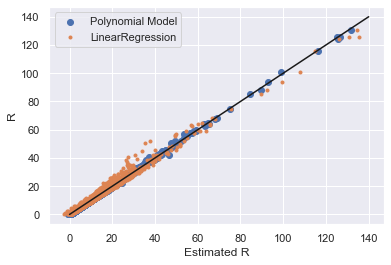

In [145]:
plt.plot([0,140],[0,140],'k')
plt.scatter(y_test_gs,ytest, label='Polynomial Model')
plt.scatter(ypred, ytest, marker='.', label='LinearRegression')
plt.legend()
plt.ylabel('R')
plt.xlabel('Estimated R')

print('Polynomial Model (order=2)')
print('R2 = ', metrics.r2_score(y_test_gs, ytest))
print('RMSE = ', np.sqrt(metrics.mean_squared_error(y_test_gs, ytest)), '\n')

print('Linear Regression')
print('R2 = ', metrics.r2_score(ypred, ytest))
print('RMSE = ', np.sqrt(metrics.mean_squared_error(ypred, ytest)))

Above shows that polynomial model can outperform linear regression

### Part 3. Random Forest

* 

In [85]:
from sklearn.ensemble import RandomForestRegressor

param_grid_rf = {'bootstrap': [True, False],  
                 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],  
                 'max_features': ['auto', 'sqrt'],  
                 'min_samples_leaf': [1, 2, 4],  
                 'min_samples_split': [2, 5, 10],  }

grid_rf = GridSearchCV(RandomForestRegressor(), param_grid_rf)

In [86]:
grid_rf.fit(Xtrain, ytrain)

/opt/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also th

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
                                       None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]})

In [87]:
# import joblib
# filename = 'rf_model.sav'
# joblib.dump(grid_rf, filename)

['rf_model.sav']

In [88]:
grid_rf.best_params_

{'bootstrap': True,
 'max_depth': 70,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [89]:
model_rf = grid_rf.best_estimator_

In [90]:
y_test_rf = model_rf.fit(Xtrain,ytrain).predict(Xtest)

/opt/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


In [106]:
from sklearn.metrics import explained_variance_score


explained_variance_score(y_test_rf.ravel(), ypred)

0.9301841581138877

In [107]:
from sklearn.metrics import r2_score


r2_score(y_test_rf.ravel(), ypred)

0.9301814087043266

In [114]:
model_rf.feature_importances_

array([0.00508739, 0.10200494, 0.04611317, 0.00746382, 0.8350269 ,
       0.00430377])

0.9838061454436873
1.0492247752870645
0.9486216875775385
1.821301013707556


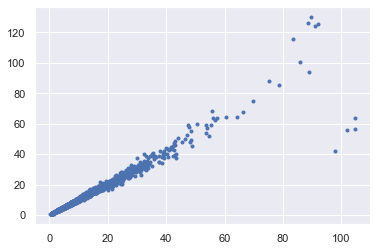

In [115]:
plt.plot(y_test_rf,ytest,'.')
print(metrics.r2_score(ypred, ytest))
print(np.sqrt(metrics.mean_squared_error(ypred, ytest)))
print(metrics.r2_score(y_test_rf, ytest))
print(np.sqrt(metrics.mean_squared_error(y_test_rf, ytest)))

### Random forest #2

In [129]:
from sklearn.model_selection import RandomizedSearchCV

grid_rf2 = RandomizedSearchCV(RandomForestRegressor(), param_grid_rf, n_iter=100, scoring="r2", n_jobs=-1)

In [130]:
grid_rf2.fit(Xtrain, ytrain)

/opt/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomizedSearchCV(estimator=RandomForestRegressor(), n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   scoring='r2')

In [131]:
model_rf2 = grid_rf2.best_estimator_
y_test_rf2 = model_rf2.fit(Xtrain,ytrain).predict(Xtest)

/opt/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


0.9838061454436873
1.0492247752870645
0.9493786707453092
1.8270735705984995


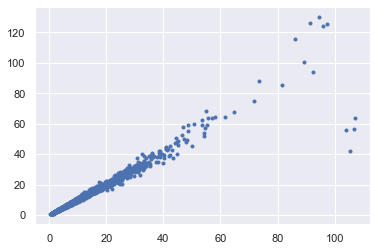

In [132]:
plt.plot(y_test_rf2,ytest,'.')
print(metrics.r2_score(ypred, ytest))
print(np.sqrt(metrics.mean_squared_error(ypred, ytest)))
print(metrics.r2_score(y_test_rf2, ytest))
print(np.sqrt(metrics.mean_squared_error(y_test_rf2, ytest)))

In [146]:
grid_rf3 = GridSearchCV(RandomForestRegressor(), param_grid_rf, scoring="r2", n_jobs=-1)

In [147]:
grid_rf3.fit(Xtrain, ytrain)

/opt/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
                                       None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='r2')

In [148]:
model_rf3 = grid_rf3.best_estimator_
y_test_rf3 = model_rf3.fit(Xtrain,ytrain).predict(Xtest)

/opt/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


0.9838061454436873
1.0492247752870645
0.9524791631811338
1.7588739355284533


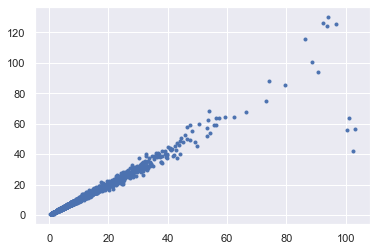

In [149]:
plt.plot(y_test_rf3,ytest,'.')
print(metrics.r2_score(ypred, ytest))
print(np.sqrt(metrics.mean_squared_error(ypred, ytest)))
print(metrics.r2_score(y_test_rf3, ytest))
print(np.sqrt(metrics.mean_squared_error(y_test_rf3, ytest)))